In [41]:
!pip install git+https://github.com/AAMIASoftwares-research/HCATNetwork.git@google-colab
!pip install git+https://github.com/AAMIASoftwares-research/DatasetUtilities.git@google-colab

  Cloning https://github.com/AAMIASoftwares-research/HCATNetwork.git (to revision google-colab) to c:\users\zaira\appdata\local\temp\pip-req-build-r899ou_g
  Resolved https://github.com/AAMIASoftwares-research/HCATNetwork.git to commit e94413cce5e4fad1a00a771112bf7e66e3501d4d
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/AAMIASoftwares-research/HCATNetwork.git 'C:\Users\zaira\AppData\Local\Temp\pip-req-build-r899ou_g'
  Running command git checkout -b google-colab --track origin/google-colab
  branch 'google-colab' set up to track 'origin/google-colab'.
  Switched to a new branch 'google-colab'


  Cloning https://github.com/AAMIASoftwares-research/DatasetUtilities.git (to revision google-colab) to c:\users\zaira\appdata\local\temp\pip-req-build-rahjq0vh
  Resolved https://github.com/AAMIASoftwares-research/DatasetUtilities.git to commit 9a1e327a6fc6b40b6191996c9bc01da4981de7c2
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Cloning https://github.com/AAMIASoftwares-research/HCATNetwork.git (to revision google-colab) to c:\users\zaira\appdata\local\temp\pip-install-u81829fw\hcatnetwork_74aecbef387f4c8bb36d6e3f08255a15
  Resolved https://github.com/AAMIASoftwares-research/HCATNetwork.git to commi

  Running command git clone --filter=blob:none --quiet https://github.com/AAMIASoftwares-research/DatasetUtilities.git 'C:\Users\zaira\AppData\Local\Temp\pip-req-build-rahjq0vh'
  Running command git checkout -b google-colab --track origin/google-colab
  branch 'google-colab' set up to track 'origin/google-colab'.
  Switched to a new branch 'google-colab'
  Running command git clone --filter=blob:none --quiet https://github.com/AAMIASoftwares-research/HCATNetwork.git 'C:\Users\zaira\AppData\Local\Temp\pip-install-u81829fw\hcatnetwork_74aecbef387f4c8bb36d6e3f08255a15'
  Running command git checkout -b google-colab --track origin/google-colab
  branch 'google-colab' set up to track 'origin/google-colab'.
  Switched to a new branch 'google-colab'


In [72]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import hcatnetwork
import HearticDatasetManager
import numpy as np
from scipy import ndimage
import random

In [73]:
# Set folder paths
ASOCA_FOLDER = "C:/Users/zaira/Documents/uni/HIGH_PERFORMANCE_COMPUTING/Neuroengineering/project/heart_data/ASOCA/"
CAT08_FOLDER = "C:/Users/zaira/Documents/uni/HIGH_PERFORMANCE_COMPUTING/Neuroengineering/project/heart_data/CAT08/"

In [108]:
# open image
image_file = os.path.join(
    ASOCA_FOLDER,
    HearticDatasetManager.asoca.DATASET_ASOCA_IMAGES_DICT["Normal"][0] 
)
image = HearticDatasetManager.asoca.AsocaImageCT(image_file)

# open graph and convert its coordinates to RAS right away
graph_file = os.path.join(
    ASOCA_FOLDER,
    HearticDatasetManager.asoca.DATASET_ASOCA_GRAPHS_RESAMPLED_05MM_DICT["Normal"][0]
)
graph = hcatnetwork.io.load_graph(
    graph_file,
    output_type=hcatnetwork.graph.SimpleCenterlineGraph
)
for node_id in graph.nodes:
    old_coords = np.array(
        [graph.nodes[node_id]["x"], graph.nodes[node_id]["y"], graph.nodes[node_id]["z"]]
    )
    new_coords = HearticDatasetManager.affine.apply_affine_3d(image.affine_centerlines2ras, old_coords)
    graph.nodes[node_id]["x"] = new_coords[0]   
    graph.nodes[node_id]["y"] = new_coords[1]
    graph.nodes[node_id]["z"] = new_coords[2]

In [109]:
# find min, max and avg radius in graph
minR = 10
maxR = 0
avgR = 0
for node_id in graph.nodes:
    r = graph.nodes[node_id]["r"]
    avgR += r
    if(r>maxR): maxR=r
    elif(r<minR): minR = r
        
avgR /= len(graph.nodes)

print(f'Min Radius: {minR}')
print(f'Max Radius: {maxR}')
print(f'Avg Radius: {avgR}')

Min Radius: 0.19999647341230686
Max Radius: 2.180273815753563
Avg Radius: 1.1610491033644552


In [110]:
# select Ostium coordinates and save radius
ids = graph.get_coronary_ostia_node_id()
coord_ostium_1 = np.array([graph.nodes[ids[0]]['x'],graph.nodes[ids[0]]['y'],graph.nodes[ids[0]]['z'],np.array([graph.nodes[ids[0]]['r']])])
coord_ostium_2 = np.array([graph.nodes[ids[1]]['x'],graph.nodes[ids[1]]['y'],graph.nodes[ids[1]]['z'],np.array([graph.nodes[ids[1]]['r']])])

In [77]:
# extract a cube from the original image
CUBE_SIDE_MM = 24
CUBE_ISOTROPIC_SPACING_MM = 0.5
CUBE_SIDE_N_SAMPLES = int(CUBE_SIDE_MM * (1/CUBE_ISOTROPIC_SPACING_MM))
NUM_CUBES_PATIENT = 100
VOXELS_PER_SIDE = CUBE_SIDE_MM/CUBE_ISOTROPIC_SPACING_MM

In [78]:
# generates coordinate matrices from x,y,z sampled points. Flattening and trasposing is then performed to generate (Nx3) arrays
def get_cube_sample_points(center: np.ndarray, side_mm: float, n_samples_per_side: int):
    """Sample a cube centered in center with side side, n_samples points."""
    xs = np.linspace(center[0] - side_mm/2, center[0] + side_mm/2, n_samples_per_side)
    ys = np.linspace(center[1] - side_mm/2, center[1] + side_mm/2, n_samples_per_side)
    zs = np.linspace(center[2] - side_mm/2, center[2] + side_mm/2, n_samples_per_side)
    return np.array(np.meshgrid(xs, ys, zs)).reshape(3, -1).T

# returns samples as a (NxNxN) array
def cube_samples_to_array(samples: np.ndarray, n_samples_per_side: int) -> np.ndarray:
    """Convert samples from a cube to a numpy array."""
    return samples.reshape(n_samples_per_side, n_samples_per_side, n_samples_per_side)

# returns directly the cube as numpy (NxNxN) array from center point in RAS coordinates
def get_input_data_from_vertex_ras_position(
        image: HearticDatasetManager.cat08.Cat08ImageCT|HearticDatasetManager.asoca.AsocaImageCT,
        position: np.ndarray,
        side_mm: float,
        n_samples_per_side: int,
        affine=np.eye(4)
    ) -> np.ndarray:
    """Get the input data from a vertex position expressed in RAS coordinates system.

    Parameters
    ----------
    image : HearticDatasetManager.cat08.Cat08ImageCT | HearticDatasetManager.asoca.AsocaImageCT
        The image from which to extract the data.
    position : numpy.ndarray
        The position of the cube center in RAS coordinates system.
    side_mm : float
        The side of the cube in mm.
    n_samples_per_side : int
        The number of samples per side.
    affine : np.ndarray, optional
        The affine transformation to apply to the position of the samples used to create the cube, by default np.eye(4) (which does nothing).
        This is useful in data augmemtation, if you want to rotate, flip, or do whatever operation
        on the cube sample points, you can do it by passing the affine transformation here.
        For example, HearticDatasetManager.affine.get_affine_3d_rotation_around_vector() will rotate the cube (see the function docs).
    """
    # Get the cube sample points
    cube_pos = get_cube_sample_points(position, side_mm, n_samples_per_side)
    # Apply transformation affine if any
    if affine is None:
        affine = np.eye(4)
    cube_pos = HearticDatasetManager.affine.apply_affine_3d(affine, cube_pos)
    # Sample the image
    samples = image.sample(cube_pos, interpolation="linear").T
    # Convert to ndarray
    cube_array = cube_samples_to_array(samples, n_samples_per_side)
    return cube_array

In [79]:
# define lists to save patches and corresponding labels
cubes = []
labels = []

# firstly random sample along the graph
for cube_i in range(NUM_CUBES_PATIENT//2):
    # choose a random node of the graph
    node_id = np.random.choice(list(graph.nodes.keys()))
    # get the position of the node in RAS
    node_position = np.array([graph.nodes[node_id]["x"], graph.nodes[node_id]["y"], graph.nodes[node_id]["z"]])
    # select parameters for random translation
    r = np.random.uniform(0, avgR*1.5)#translation vector
    theta = np.random.uniform(0, 2*np.pi)#xy plane angle
    phi = np.random.uniform(0, np.pi)#z to xy plane angle
    # apply the translation to the selected point
    node_position += np.array([r*np.sin(phi)*np.cos(theta), r*np.sin(phi)*np.sin(theta), r*np.cos(phi)]).reshape(3,1)
    cube_array = get_input_data_from_vertex_ras_position(image,node_position,CUBE_SIDE_MM,CUBE_SIDE_N_SAMPLES)
    # compute distances from ostia to assign labels
    dist1 = np.sqrt(np.sum(np.square(coord_ostium_1[:3]-node_position)))
    dist2 = np.sqrt(np.sum(np.square(coord_ostium_2[:3]-node_position)))
    label = 1 if (dist1<=1.2*coord_ostium_1[-1] or dist2<=1.2*coord_ostium_2[-1]) else 0
    
    cubes.append(cube_array)
    labels.append(label)
    
cubes = np.array(cubes)
labels = np.array(labels)

In [80]:
# check dimensionality
print(f"Dim. cubes: {cubes.shape}")
print(f"Dim. labels: {labels.shape}")
# check the label distribution, expect none to very few class 1 samples 
print(f"Ostium labels: {np.sum(labels==1)}")

Dim. cubes: (50, 48, 48, 48)
Dim. labels: (50,)
Ostium labels: 1


In [81]:
# reconvert to list
cubes = list(cubes)
labels = list(labels)

In [82]:
# then sample locally from the ostia
for cube_i in range(NUM_CUBES_PATIENT//2):
    # select one of the two ostia
    node_id = np.random.choice(ids)
    # get the position of the node in RAS
    node_position = np.array([graph.nodes[node_id]["x"], graph.nodes[node_id]["y"], graph.nodes[node_id]["z"]])
    # select parameters for random translation
    r = np.random.uniform(-graph.nodes[node_id]["r"]*1.2, graph.nodes[node_id]["r"]*1.2)#translation vector
    theta = np.random.uniform(0, 2*np.pi)#xy plane angle
    phi = np.random.uniform(0, np.pi)#z to xy plane angle
    # apply the translation to the selected point
    node_position += np.array([r*np.sin(phi)*np.cos(theta), r*np.sin(phi)*np.sin(theta), r*np.cos(phi)]).reshape(3,1)
    cube_array = get_input_data_from_vertex_ras_position(image,node_position,CUBE_SIDE_MM,CUBE_SIDE_N_SAMPLES)
    # compute distances from ostia to assign labels
    dist1 = np.sqrt(np.sum(np.square(coord_ostium_1[:3]-node_position)))
    dist2 = np.sqrt(np.sum(np.square(coord_ostium_2[:3]-node_position)))
    label = 1 if (dist1<=1.2*coord_ostium_1[-1] or dist2<=1.2*coord_ostium_2[-1]) else 0
    
    cubes.append(cube_array)
    labels.append(label)
    
cubes = np.array(cubes)
labels = np.array(labels)


In [53]:
# print(cubes)

In [83]:
# check dimensionality
print(f"Dim. cubes: {cubes.shape}")
print(f"Dim. labels: {labels.shape}")
# check label distribution, now expect even size
print(f"Ostium labels: {np.sum(labels==1)}")

Dim. cubes: (100, 48, 48, 48)
Dim. labels: (100,)
Ostium labels: 51


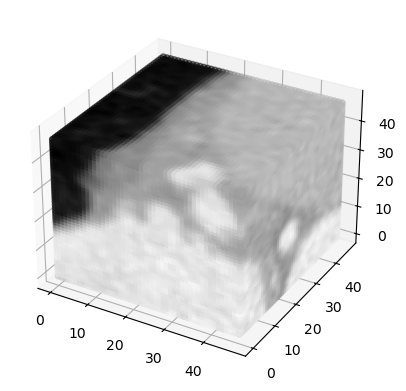

In [86]:
# plot label 0 cube
first_sample = cubes[0]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# Get the indices for each dimension
# x, y, z = np.meshgrid(np.arange(48), np.arange(48), np.arange(48))
x, y, z = np.meshgrid(np.arange(VOXELS_PER_SIDE), np.arange(VOXELS_PER_SIDE), np.arange(VOXELS_PER_SIDE))

# Flatten the arrays for plotting
x = x.flatten()
y = y.flatten()
z = z.flatten()
values = first_sample.flatten()

# Scatter plot
ax.scatter(x, y, z, c=values, cmap='gray')

# Show the plot
plt.show()

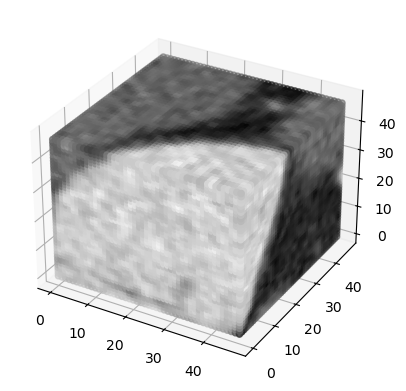

In [87]:
# plot label 1 cube
last_sample = cubes[99]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# Get the indices for each dimension
x, y, z = np.meshgrid(np.arange(VOXELS_PER_SIDE), np.arange(VOXELS_PER_SIDE), np.arange(VOXELS_PER_SIDE))

# Flatten the arrays for plotting
x = x.flatten()
y = y.flatten()
z = z.flatten()
values = last_sample.flatten()

# Scatter plot
ax.scatter(x, y, z, c=values, cmap='gray')

# Show the plot
plt.show()

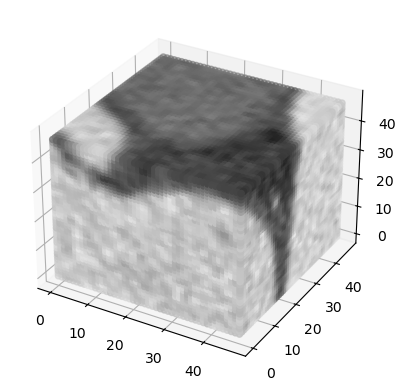

In [88]:
# original ostium 1
node_id = ids[0]
# get the position of the node in RAS
node_position = np.array([graph.nodes[node_id]["x"], graph.nodes[node_id]["y"], graph.nodes[node_id]["z"]])
cube_array_1 = get_input_data_from_vertex_ras_position(image,node_position,CUBE_SIDE_MM,CUBE_SIDE_N_SAMPLES)

# show it
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# Get the indices for each dimension
x, y, z = np.meshgrid(np.arange(VOXELS_PER_SIDE), np.arange(VOXELS_PER_SIDE), np.arange(VOXELS_PER_SIDE))

# Flatten the arrays for plotting
x = x.flatten()
y = y.flatten()
z = z.flatten()
values = cube_array_1.flatten()

# Scatter plot
ax.scatter(x, y, z, c=values, cmap='gray')

# Show the plot
plt.show()

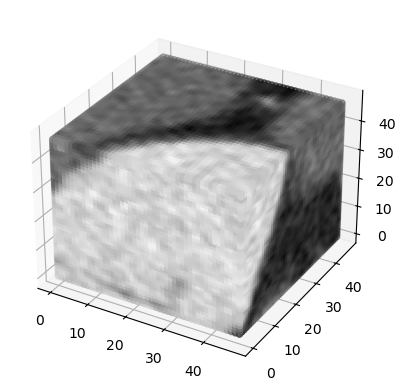

In [89]:
# original ostium 1
node_id = ids[1]
# get the position of the node in RAS
node_position = np.array([graph.nodes[node_id]["x"], graph.nodes[node_id]["y"], graph.nodes[node_id]["z"]])
cube_array_2 = get_input_data_from_vertex_ras_position(image,node_position,CUBE_SIDE_MM,CUBE_SIDE_N_SAMPLES)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# Get the indices for each dimension
x, y, z = np.meshgrid(np.arange(VOXELS_PER_SIDE), np.arange(VOXELS_PER_SIDE), np.arange(VOXELS_PER_SIDE))

# Flatten the arrays for plotting
x = x.flatten()
y = y.flatten()
z = z.flatten()
values = cube_array_2.flatten()

# Scatter plot
ax.scatter(x, y, z, c=values, cmap='gray')

# Show the plot
plt.show()

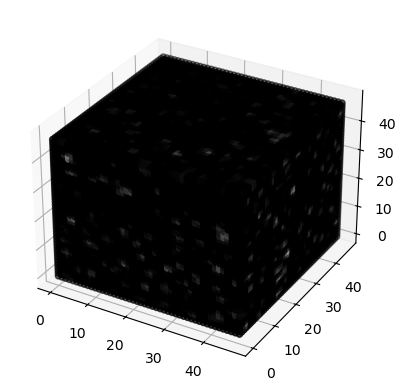

In [90]:
import skimage
cube_array_1_frangi = skimage.filters.frangi(cube_array_1)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# Get the indices for each dimension
x, y, z = np.meshgrid(np.arange(VOXELS_PER_SIDE), np.arange(VOXELS_PER_SIDE), np.arange(VOXELS_PER_SIDE))

# Flatten the arrays for plotting
x = x.flatten()
y = y.flatten()
z = z.flatten()
values = cube_array_1_frangi.flatten()

# Scatter plot
ax.scatter(x, y, z, c=values, cmap='gray')

# Show the plot
plt.show()

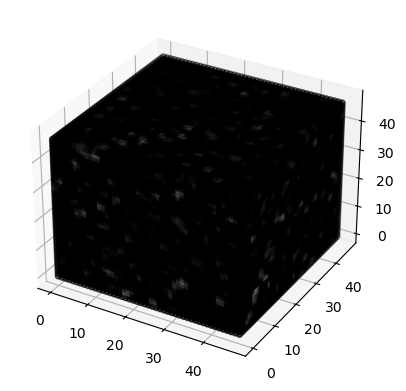

In [91]:
cube_array_2_frangi = skimage.filters.frangi(cube_array_2)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# Get the indices for each dimension
x, y, z = np.meshgrid(np.arange(VOXELS_PER_SIDE), np.arange(VOXELS_PER_SIDE), np.arange(VOXELS_PER_SIDE))

# Flatten the arrays for plotting
x = x.flatten()
y = y.flatten()
z = z.flatten()
values = cube_array_2_frangi.flatten()

# Scatter plot
ax.scatter(x, y, z, c=values, cmap='gray')

# Show the plot
plt.show()

FIRST TRY WITH CNN

In [92]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
import numpy as np

import os


In [102]:
#load data
dataset = tf.data.Dataset.from_tensor_slices((cubes, labels))
print(dataset)
# for ele in dataset:
#     print(ele)

#shuffle the data
buffer_size = 1000
dataset = dataset.shuffle(buffer_size).batch(32)
dataset.element_spec



<TensorSliceDataset element_spec=(TensorSpec(shape=(48, 48, 48), dtype=tf.float64, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>


(TensorSpec(shape=(None, 48, 48, 48), dtype=tf.float64, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [103]:
#build train and validation sets
num_samples = len(cubes)
num_train_samples = int(0.8*num_samples)
num_val_samples = num_samples - num_train_samples

# Split the dataset into training and validation sets
train_dataset = dataset.take(num_train_samples)
val_dataset = dataset.skip(num_train_samples)

print("Number of samples in train and validation are %d and %d."
    % (num_train_samples, num_val_samples))

train_dataset.element_spec

Number of samples in train and validation are 80 and 20.


(TensorSpec(shape=(None, 48, 48, 48), dtype=tf.float64, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [64]:
#data augmentation


In [104]:
#defining the model
def get_model(width=48, height=48, depth=48):
    """Build a 3D convolutional neural network model."""
    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=48, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=48, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=96, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=192, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=384, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="first_try")
    return model


# Build model.
model = get_model(width=48, height=48, depth=48)
model.summary()

Model: "first_try"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 48, 48, 48, 1)]   0         
                                                                 
 conv3d_38 (Conv3D)          (None, 46, 46, 46, 48)    1344      
                                                                 
 max_pooling3d_38 (MaxPoolin  (None, 23, 23, 23, 48)   0         
 g3D)                                                            
                                                                 
 batch_normalization_36 (Bat  (None, 23, 23, 23, 48)   192       
 chNormalization)                                                
                                                                 
 conv3d_39 (Conv3D)          (None, 21, 21, 21, 48)    62256     
                                                                 
 max_pooling3d_39 (MaxPoolin  (None, 10, 10, 10, 48)   0 

In [66]:
# #example above, but with some dropout layers and regularization in convolutional layers
# def get_model(width=20, height=20, depth=20):
#     """Build a 3D convolutional neural network model."""
#     size = depth
#     inputs = keras.Input((width, height, depth, 1))

#     x = layers.Conv3D(filters=20, kernel_size=1, activation="relu", kernel_regularizer=regularizers.l2(0.01))(inputs)
#     x = layers.MaxPool3D(pool_size=2)(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Dropout(0.3)(x)

#     x = layers.Conv3D(filters=20, kernel_size=1, activation="relu", kernel_regularizer=regularizers.l2(0.01))(x)
#     x = layers.MaxPool3D(pool_size=2)(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Dropout(0.3)(x)

#     x = layers.Conv3D(filters=40,kernel_size=1, activation="relu", kernel_regularizer=regularizers.l2(0.01))(x)
#     x = layers.MaxPool3D(pool_size=2)(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Dropout(0.3)(x)

#     x = layers.Conv3D(filters=80, kernel_size=1, activation="relu", kernel_regularizer=regularizers.l2(0.01))(x)
#     x = layers.MaxPool3D(pool_size=2)(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Dropout(0.3)(x)

#     x = layers.GlobalAveragePooling3D()(x)
#     x = layers.Dense(units=160, activation="relu", kernel_regularizer=regularizers.l2(0.01))(x)
#     x = layers.Dropout(0.5)(x)  # Increased dropout for regularization

#     outputs = layers.Dense(units=1, activation="sigmoid")(x)

#     # Define the model.
#     model = keras.Model(inputs, outputs, name="improved_first_model")
#     return model

# # Build the improved model.
# model = get_model(width=20, height=20, depth=20)
# model.summary()

In [67]:
# #defining the model
# #one huge max pooling layer at the end, with convolutional layers with batch normalization and activation in between
# def get_model(width=48, height=48, depth=48):
#     """Build a 3D convolutional neural network model."""
#     size = depth
#     inputs = keras.Input((width, height, depth, 1))

#     x = layers.Conv3D(filters=48, kernel_size=3, activation="relu")(inputs)
#     x = layers.BatchNormalization()(x)
#     x = layers.Activation("relu")(x)

#     x = layers.Conv3D(filters=48, kernel_size=3, activation="relu")(inputs)
#     x = layers.BatchNormalization()(x)
#     x = layers.Activation("relu")(x)

#     x = layers.Conv3D(filters=48, kernel_size=3, activation="relu")(inputs)
#     x = layers.BatchNormalization()(x)
#     x = layers.Activation("relu")(x)

#     x= layers.MaxPool3D(pool_size=2)(x)

#     outputs = layers.Dense(units=1, activation="sigmoid")(x)

#     # Define the model.
#     model = keras.Model(inputs, outputs, name="second_try")
#     return model


# # Build model.
# model = get_model(width=48, height=48, depth=48)
# model.summary()

In [105]:
#training
# Compile model.
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)

# Define callbacks.
# checkpoint_cb = keras.callbacks.ModelCheckpoint(
#     "3d_image_classification.h5", save_best_only=True
# )
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

# Train the model, doing validation at the end of each epoch
epochs = 100
model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[early_stopping_cb],
)

Epoch 1/100
4/4 - 2s - loss: 0.4603 - acc: 0.7800 - 2s/epoch - 621ms/step
Epoch 2/100
4/4 - 1s - loss: 0.0594 - acc: 0.9900 - 1s/epoch - 319ms/step
Epoch 3/100
4/4 - 1s - loss: 0.0364 - acc: 0.9900 - 1s/epoch - 312ms/step
Epoch 4/100
4/4 - 1s - loss: 0.0198 - acc: 1.0000 - 1s/epoch - 311ms/step
Epoch 5/100
4/4 - 1s - loss: 0.0311 - acc: 0.9900 - 1s/epoch - 314ms/step
Epoch 6/100
4/4 - 1s - loss: 0.0114 - acc: 1.0000 - 1s/epoch - 312ms/step
Epoch 7/100
4/4 - 1s - loss: 0.0082 - acc: 1.0000 - 1s/epoch - 318ms/step
Epoch 8/100
4/4 - 1s - loss: 0.0519 - acc: 0.9900 - 1s/epoch - 311ms/step
Epoch 9/100
4/4 - 1s - loss: 0.0094 - acc: 1.0000 - 1s/epoch - 315ms/step
Epoch 10/100
4/4 - 1s - loss: 0.0126 - acc: 1.0000 - 1s/epoch - 319ms/step
Epoch 11/100
4/4 - 1s - loss: 0.0336 - acc: 0.9900 - 1s/epoch - 322ms/step
Epoch 12/100
4/4 - 1s - loss: 0.0209 - acc: 0.9900 - 1s/epoch - 313ms/step
Epoch 13/100
4/4 - 1s - loss: 0.0090 - acc: 1.0000 - 1s/epoch - 313ms/step
Epoch 14/100
4/4 - 1s - loss: 0.01

KeyError: 'val_acc'

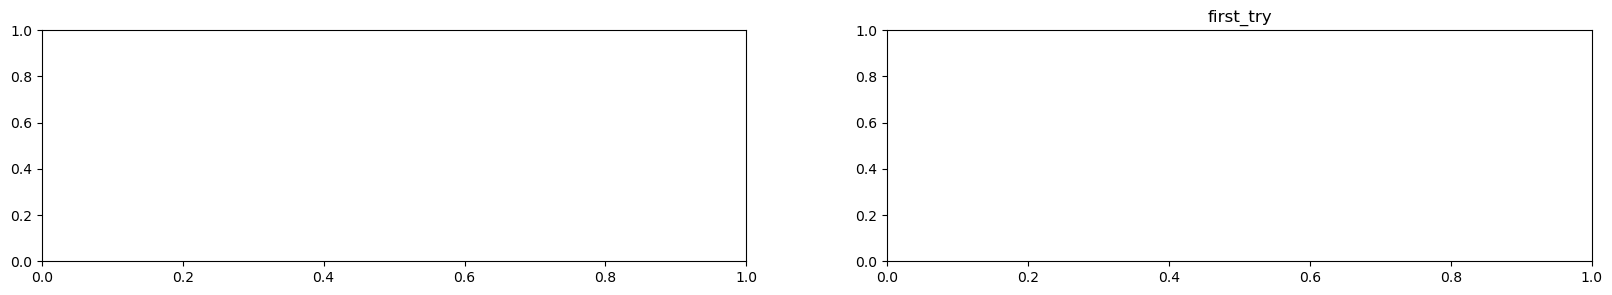

In [107]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
plt.title(model.name)
ax = ax.ravel()
for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])
